# Data Analysis
## Client
Erin Robinson: Buyer	
- Invest in poor neighborhood
- buying & selling 
- costs back + little profit
- socially responsible

Erin wants to buy property in poor neighbourhoods to create, renovate and maintain affordable living space for rent and selling. Since she is responsible, renovating outdated property is possible. With Erins private resources, houses shall be bought, possibly renovated and the new property shall be transfered into a community oriented fund.

## Questions:
1. What parameters describe a poor neighbourhood based on the house data?
2. Where are those poor neighbourhoods located
3. In which of those neighbourhoods is the renovated fraction especially small and houses are reletively old and condition or grade is rather bad -> These are the neighborhoods in most need of development 

### Question 1. : What parameters describe a poor neighbourhood based on the house data?
#### Assumptions:
- low price / m^2
- small lot area
- small living area
- bad condition
- bad grade

#### Further Information: Poverty rate

The poverty rate is the ratio of the number of people (in a given age group) whose income falls below the poverty line; taken as half the median household income of the total population.
The povery rate among all age groups in the US is 0.151
(OECD (2023), Poverty rate (indicator). doi: 10.1787/0fe1315d-en (Accessed on 26 January 2023))

#### Methods
- price per m^2 <= perc(15)
- lot area <= perc(15)
- living area <= perc(15)
- condition <= perc(15)
- grade <= perc(15)

In [ ]:
### Setup
import pandas as pd
import numpy as np
# import missingno as msn
# import plotly.express as px
# import datetime as dt
from plotnine import *
from functools import reduce

df_hs = pd.read_pickle("./data/df_houses_cleaned.pkl")

In [ ]:
### Question 1. : What parameters describe a poor neighbourhood based on the house data?

### Calculate price / m^2
df_hs["price_living_sqm"] = (df_hs.price / df_hs.a_living_sqm).round(2)
df_hs["price_lot_sqm"] = (df_hs.price / df_hs.a_lot_sqm).round(2)



In [ ]:
### Calculate percentile as dictionary for: price_living_sqm, price_lot_sqm, a_living_sqm, grade, condition
col_perc_15 = {} # dictionary to be filled
cols = ["price", "price_living_sqm", "price_lot_sqm", "a_living_sqm", "grade", "condition"] # columns to apply perc on
for col in cols:
    
    col_perc_15[col] = df_hs[col].quantile(0.15)

del col
col_perc_15


In [ ]:
### Define boolean series for those columns wether the entry in the respective column is <= the perc(15)
col_test_perc_15 = {}
for col in cols:
    series_col = df_hs[col] <= col_perc_15[col]
    col_test_perc_15[col] = series_col

### Save it as DataFrame
df_perc_15 = pd.DataFrame.from_dict(col_test_perc_15)
### Find out, wether this was a smart choice?
### Do the columns "price_living_sqm", "price_lot_sqm", "a_living_sqm", "grade", "condition" correlate?

### Create a correlation matrix of the columns of interest
df_corr_1 = df_hs[cols].corr(method = "spearman")

### Names for indexes
new_ind = {}
k = 0
for col in cols:
    new_ind[k] = col
    k += 1

df_corr_1.rename (index = new_ind, inplace = True)

### Create a correlation plot
df_corr_1 = df_corr_1.melt(ignore_index = False).rename_axis ("index1").reset_index()
df_corr_1.rename ({'index1':'var_1', 'variable':'var_2', 'value':'spearman_correlation'}, inplace = True, axis = 1)
df_corr_1["lab_text"] = df_corr_1.spearman_correlation.round(2).astype("str")


In [ ]:
P3 = ggplot(df_corr_1, aes(x = "var_2", y = "var_1", fill = "spearman_correlation")) + \
    geom_tile() + \
    geom_label(
        aes (label = "lab_text"),
                fill = "white",
                size = 8) + \
    scale_fill_distiller() + \
    theme_minimal() + \
    labs(title = "Housing characteristics - Correlation Matrix", x = "", y = "") + \
    theme (axis_text_x = element_text(rotation = 45, hjust = 1),
            figure_size = (8,6))

ggsave (P3, )

### Question 1: Takeaways

- Correlation graph as it is now not well suited - lowest correlations have the highest numbers
- The larger the living area, the higher the grade (0.72)
- The grade rises slightly with the area price
- The price per area rises only slightly with the condition
- The grade rises with the price per lot area
- The price rises with the grade
- The median price for houses in condition 1 and 2 seems to be 100000$ lower than 3-5. Therefore focus on those houses

### Question 2: Where might poor neighborhoods based on the housing data be located?

#### Methods:
- Compare percentage of houses with low price per sqm (<= perc(15)) between zip codes
- Plot the most promising locations

In [ ]:
### Meaningful zip-code and house data?

df_zip_count = df_hs.groupby("zipcode", as_index = False).count()[["zipcode", "id_house"]]
df_zip_count # 70 zipcodes
df_zip_count.describe().round(2) # with a mean of 308 houses each between 50 and 600 houses

In [ ]:
### Percentage of houses per zip-code below the price per area living 15 th percentile
cols_subset = cols + ["zipcode", "id_house"] # subset of columns for further investigation
### concat cols and the boolean information on the percentile

### Or cleaer differientiating by price?

In [ ]:
### Concatenate df_hs with only columns of interest and df_perc_15
new_cols = {}
for col in list(df_perc_15.columns):
    new_cols[col] = "under15_" + col

df_perc_15.rename(new_cols, axis = 1, inplace = True)

### df of interest with columns of interest and wether they are below their respt 15 perc
df_hs_intr = pd.concat([df_hs[cols_subset], df_perc_15], axis = 1)


In [70]:
### Function to calculate the ratio of houses below the 15th perc for the corresponding column
### eg for column price: calculates for each zipcode, the ratio of house prices under the 15th percentile 
### of house prices from the whole county

def ratio_group(df, col_name, group_factor = "zipcode"):
    col_perc15 = "under15_" + col_name # name of colum with corresponding boolean <= perc 15
    df_gr = df.groupby([group_factor, col_perc15], as_index = False).count()[[group_factor, col_perc15, "id_house"]]
    df_gr.rename({"id_house":"n_houses"}, axis = 1, inplace = True)

# Calculates the ratio only for those zipcodes, where there are houses below the 15th percentile of the corresponding
# column
    def ratio_perc15(df_2):
        ind = df_2[col_perc15] == True
        new_col_rat = "ratio_" + col_perc15 # new name for ratio column
        df_2[new_col_rat] = df_2.n_houses[ind] / sum (df_2.n_houses)
        return df_2

    df_gr = df_gr.groupby(group_factor, as_index = False).apply(ratio_perc15)
    df_gr = df_gr[df_gr[col_perc15] == True]
    return df_gr.iloc[:,[0,3]]

### Apply to all columns of interest - create a list with a df for each column of interes
### (price, price per sqm, area living space and lot, condition, grade)
ratios_zip = []
for x in cols:
    ratios_zip.append(ratio_group(df_hs_intr, x))


### Combine dfs in list into one df
df_ratios = reduce (lambda df1, df2: df1.merge (df2, on = "zipcode", how = "outer"), ratios_zip)

### Compare info on the whole new df of ratios 
df_ratios.info()
### with length of dfs in the original list
for x in ratios_zip:
    print (len(x))

### df_ratios can be now used for searching for the right zipcode


<class 'pandas.core.frame.DataFrame'>
Int64Index: 70 entries, 0 to 69
Data columns (total 7 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   zipcode                         70 non-null     int64  
 1   ratio_under15_price             57 non-null     float64
 2   ratio_under15_price_living_sqm  60 non-null     float64
 3   ratio_under15_price_lot_sqm     57 non-null     float64
 4   ratio_under15_a_living_sqm      70 non-null     float64
 5   ratio_under15_grade             70 non-null     float64
 6   ratio_under15_condition         70 non-null     float64
dtypes: float64(6), int64(1)
memory usage: 4.4 KB


/Users/gunnaroehmichen/neuefische/ds-eda-project-gunnar-oeh/.venv/lib/python3.9/site-packages/plotnine/layer.py:333: PlotnineWarning: stat_boxplot : Removed 36 rows containing non-finite values.


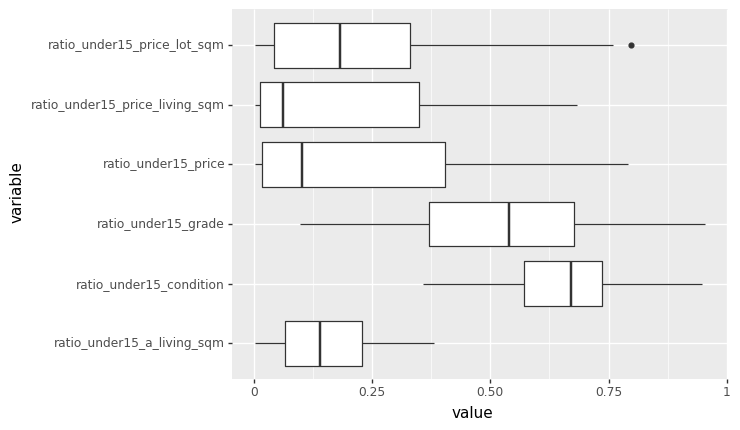

<ggplot: (378112458)>

In [82]:
df_ratios_long = df_ratios.melt(id_vars = "zipcode")
df_ratios_long["zip_str"] = df_ratios_long.zipcode.astype("str")

P5 = ggplot(df_ratios_long, aes (x = "variable", y = "value")) + geom_boxplot() + coord_flip()
P5
